<a href="https://colab.research.google.com/github/Kiran771/AIvsHumanWrittenText/blob/main/logistic_regresion(ai_human).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install visualization libraries for word cloud generation
!pip install wordcloud matplotlib

In [ ]:
# import all the required libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix,roc_curve, roc_auc_score,ConfusionMatrixDisplay, precision_recall_curve, average_precision_score,log_loss
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

In [ ]:
# Load Dataset
df=pd.read_csv('/content/AI-Human.csv')

In [ ]:
# view the dataset
df.head()

,title,abstract,label
0,Epigenetic inheritance of circadian period in ...,\n\nThis study focuses on the epigenetic inher...,1
1,Pediatric Airway Stent Designed to Facilitate ...,Objective: The goal was to develop a pediatric...,0
2,Infection prevention and control in paediatric...,Transmission of infection in the paediatric of...,0
3,"Correlation between thyroid function, testoste...",STUDY DESIGN: Prospective case series. OBJECTI...,0
4,Natural intertypic and intratypic recombinants...,\n\nThis study aims to analyze the recombinant...,1


In [ ]:
# Check dataset size
df.shape

(28662, 3)

In [ ]:
# Check data types of each column
df.dtypes

,0
title,object
abstract,object
label,int64


In [ ]:
# check class imbalance
label_counts=df['label'].value_counts()

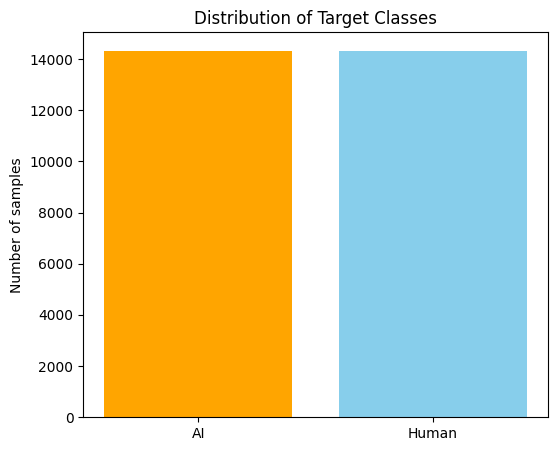

In [ ]:
# Visualize class distribution with a bar chart
plt.figure(figsize=(6,5))
plt.bar(label_counts.index, label_counts.values, color=['skyblue', 'orange'])
plt.xticks(label_counts.index, ['Human', 'AI'])
plt.ylabel('Number of samples')
plt.title('Distribution of Target Classes')

plt.show()

In [ ]:
# combine title and abstract column
df['text'] = df['title'].fillna('') + ' ' + df['abstract'].fillna('')


In [ ]:
# Display a sample text from the dataset
df['text'][1]

'Pediatric Airway Stent Designed to Facilitate Mucus Transport and Atraumatic Removal Objective: The goal was to develop a pediatric airway stent for treating tracheobronchomalacia that could be used as an alternative to positive pressure ventilation. The design goals were for the stent to allow mucus flow and to resist migration inside the airways, while also enabling easy insertion and removal. Methods: A helical stent design, together with insertion and removal tools, is presented. A mechanics model of stent compression is derived to assist in selecting stent design parameters (pitch and wire diameter) that provide the desired amount of tracheal support, while introducing the minimal amount of foreign material into the airway. Worst-case airway area reduction with stent support is investigated experimentally using a pressurized tracheal phantom matched to porcine tracheal tissue properties. The stent design is then evaluated in a porcine in vivo experiment. Results: Phantom testing 

In [ ]:
# Textpreprocessing step
def preprocess_text(text):

  # handle missing values
  if pd.isna(text):
    return ""
  # convert to string
  text=str(text)

  # remove HTML tags
  text = re.sub(r'<[^>]+>', ' ', text)

  # remove URLs
  text = re.sub(r'http[s]?://\S+', ' ', text)

  # remove email address
  text = re.sub(r'\S+@\S+', ' ', text)


  # replace multiple newlines with single space
  text = re.sub(r'\n+',' ', text )

  # Replace tabs with space
  text = re.sub(r'\t+', ' ', text)

  # remove excessive spaces 3+ to 1
  text = re.sub(r' {3,}', ' ', text)

  # remove leading or trailing whitespace
  text=text.strip()

  return text

In [ ]:
# Apply preprocessing to create cleaned text column
df['clean_text']=df['text'].apply(preprocess_text)

In [ ]:
# separating feature and target column
x=df['clean_text']
y=df['label']

In [ ]:
# split the dataset into train and test
x_temp,x_test,y_temp,y_test=train_test_split(x,y,test_size=0.10,random_state=42,stratify=y)

In [ ]:
# split the training set into train and validaton
x_train,x_val,y_train,y_val=train_test_split(x_temp,y_temp,test_size=0.10,random_state=42,stratify=y_temp)

In [ ]:
# Check the size of learned vocabulary
vocab_size = len(vectorizer.vocabulary_)
print("Vocabulary size:", vocab_size)

Vocabulary size: 2000


In [ ]:
# Initialize TF-IDF vectorizer for feature extraction
vectorizer=TfidfVectorizer(
    lowercase=True,
    stop_words='english',
    # ngram_range=(1,1),
    max_features=2000,
    ngram_range=(1,2),
    min_df=2,
    max_df=0.85
)

In [ ]:
# Transform training text to TF-IDF features
x_train_tfidf=vectorizer.fit_transform(x_train)

In [ ]:
# Transform validation and test sets using fitted vectorizer
x_val_tfidf= vectorizer.transform(x_val)
x_test_tfidf= vectorizer.transform(x_test)

In [ ]:
# Generate word cloud from top TF-IDF features for a given class
def wordcloud_top_features(X, y, class_label, feature_names, n=50, colormap='Blues'):

    # Ensure y is a NumPy array
    y_array = y.to_numpy() if hasattr(y, 'to_numpy') else np.array(y)

    # Get indices for the selected class
    class_indices = np.where(y_array == class_label)[0]

    # Sum TF-IDF values for the class
    class_sum = X[class_indices].sum(axis=0)
    class_sum_array = np.asarray(class_sum).flatten()

    # Get top N indices
    top_idx = class_sum_array.argsort()[::-1][:n]

    # Create dictionary for WordCloud
    word_freq = {feature_names[i]: class_sum_array[i] for i in top_idx}

    # Generate WordCloud
    wc = WordCloud(width=800, height=400, background_color='white', colormap=colormap)
    wc.generate_from_frequencies(word_freq)

    return wc


In [ ]:
# Get feature names from vectorizer
feature_names = vectorizer.get_feature_names_out()

# Generate word clouds for top features by class
wc_human = wordcloud_top_features(x_train_tfidf, y_train, class_label=0, feature_names=feature_names, n=50, colormap='Blues')
wc_ai    = wordcloud_top_features(x_train_tfidf, y_train, class_label=1, feature_names=feature_names, n=50, colormap='Oranges')


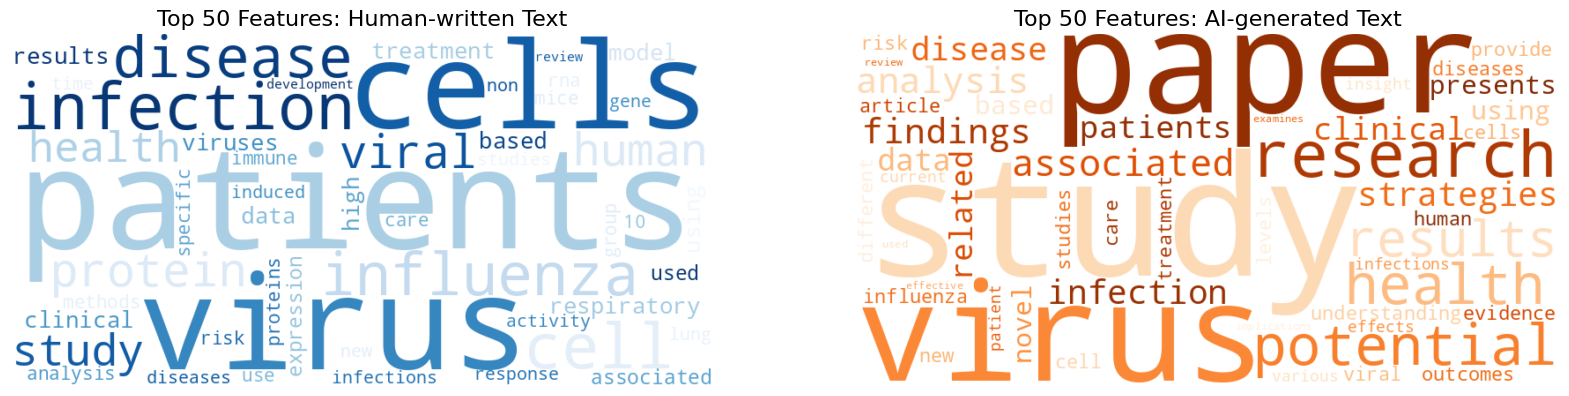

In [ ]:
# Plot word-cloud
plt.figure(figsize=(20,10))

# Human
plt.subplot(1,2,1)
plt.imshow(wc_human, interpolation='bilinear')
plt.axis('off')
plt.title('Top 50 Features: Human-written Text', fontsize=16)

# AI
plt.subplot(1,2,2)
plt.imshow(wc_ai, interpolation='bilinear')
plt.axis('off')
plt.title('Top 50 Features: AI-generated Text', fontsize=16)

plt.show()


# Logistic Regressin with L2 regularization

In [ ]:
# Initialize Logistic Regression with L2 regularization
model_l2 = LogisticRegression(penalty="l2", solver="liblinear", max_iter=1000)

In [ ]:
# Train the model on TF-IDF features
model_l2.fit(x_train_tfidf, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [ ]:
# Evaluate model performance on validation set
y_val_pred = model_l2.predict(x_val_tfidf)
print("Validation Accuracy (L2):", accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))

Validation Accuracy (L2): 0.9724806201550388
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1290
           1       0.98      0.96      0.97      1290

    accuracy                           0.97      2580
   macro avg       0.97      0.97      0.97      2580
weighted avg       0.97      0.97      0.97      2580



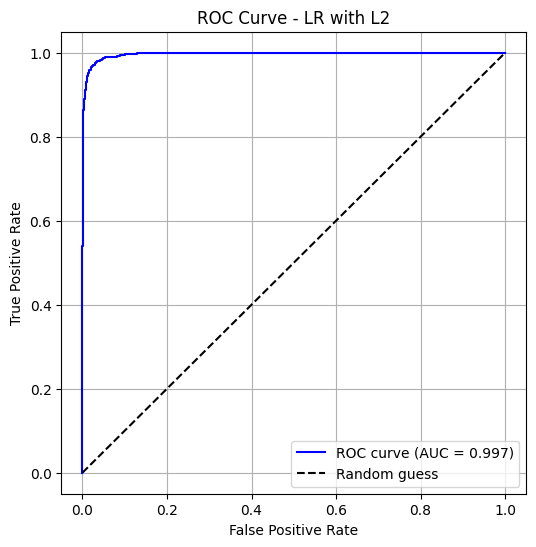

In [ ]:

# Get predicted probabilities for positive class
y_test_prob=model_l2.predict_proba(x_test_tfidf)[:,1]

# Calculate ROC curve metrics
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
auc = roc_auc_score(y_test, y_test_prob)

# Plot ROC curve to visualize classification performance
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.3f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LR with L2')
plt.legend()
plt.grid(True)
plt.show()

Train Loss: 0.12233626604429612
Validation Loss: 0.1331250678417348


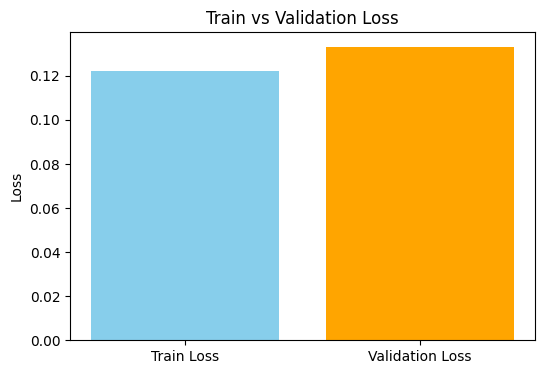

In [ ]:
# Get probability predictions for train and validation sets
y_train_proba = model_l2.predict_proba(x_train_tfidf)
y_val_proba   = model_l2.predict_proba(x_val_tfidf)

# Compute log loss to check for overfitting
train_loss = log_loss(y_train, y_train_proba)
val_loss   = log_loss(y_val, y_val_proba)

print("Train Loss:", train_loss)
print("Validation Loss:", val_loss)

# Visualize training vs validation loss
plt.figure(figsize=(6,4))
plt.bar(['Train Loss', 'Validation Loss'], [train_loss, val_loss], color=['skyblue', 'orange'])
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.show()

# Logistic Regression without l2 regularization

In [ ]:
# Initialize Logistic Regression without regularization
model_no_l2 = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000)


In [ ]:
# Train the model without regularization on training data
model_no_l2.fit(x_train_tfidf, y_train)

LogisticRegression(max_iter=1000, penalty=None)

In [ ]:
# Generate predictions and evaluate unregularized model
y_val_pred = model_no_l2.predict(x_val_tfidf)
print("Validation Accuracy (wihout l2):", accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))

Validation Accuracy (wihout l2): 0.9697674418604652
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1290
           1       0.97      0.97      0.97      1290

    accuracy                           0.97      2580
   macro avg       0.97      0.97      0.97      2580
weighted avg       0.97      0.97      0.97      2580



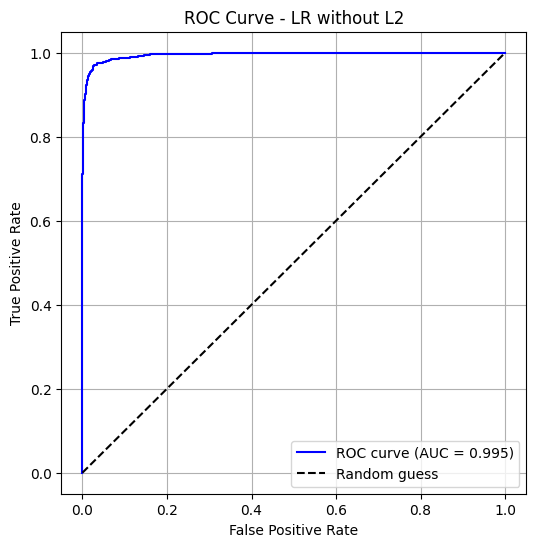

In [ ]:
# Get predicted probabilities for positive class
y_val_proba = model_no_l2.predict_proba(x_val_tfidf)[:, 1]

# Calculate ROC curve metrics
fpr, tpr, thresholds = roc_curve(y_val, y_val_proba)
auc = roc_auc_score(y_val, y_val_proba)

# Plot ROC curve (validation set) to visualize classification performance
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.3f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LR without L2')
plt.legend()
plt.grid(True)
plt.show()

# Prediction on test set

In [ ]:
# Evaluate final model performance on test set
y_test_predict=model_l2.predict(x_test_tfidf)
print("Test accuracy (L2):", accuracy_score(y_test, y_test_predict))
print(classification_report(y_test, y_test_predict))

Test accuracy (L2): 0.9720962678758284
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1434
           1       0.97      0.97      0.97      1433

    accuracy                           0.97      2867
   macro avg       0.97      0.97      0.97      2867
weighted avg       0.97      0.97      0.97      2867



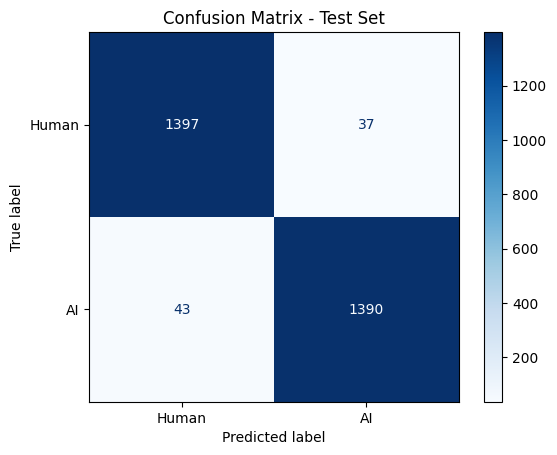

In [ ]:
# Generate confusion matrix for test set predictions
confusionMatrix= confusion_matrix(y_test, y_test_predict)

# Visualize confusion matrix with class labels
disp = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix, display_labels=['Human', 'AI'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - Test Set')
plt.show()

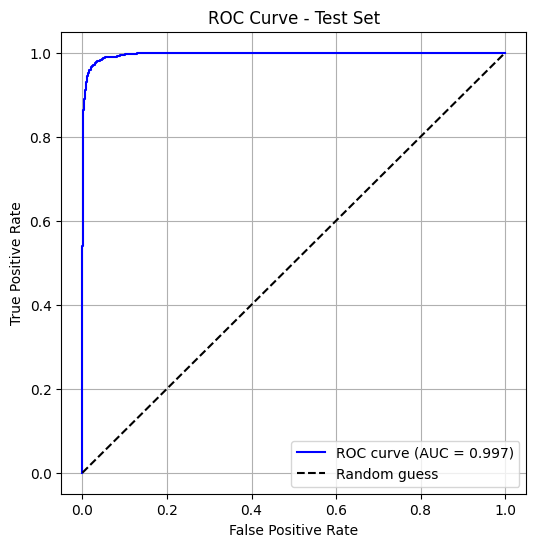

In [ ]:
# Get predicted probabilities for positive class
y_test_proba = model_l2.predict_proba(x_test_tfidf)[:, 1]

# Calculate ROC curve metrics
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
auc = roc_auc_score(y_test, y_test_proba)

# Plot ROC curve on test set
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.3f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Test Set')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Calculate PR curve metrics and AP score
precision, recall, thresholds = precision_recall_curve(y_test, y_test_proba)
ap_score = average_precision_score(y_test, y_test_proba)


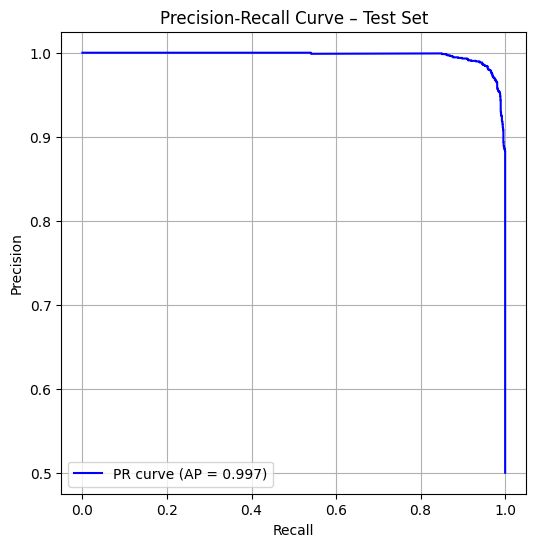

In [ ]:
# Plot Precision-Recall curve to evaluate model performance on the test set

plt.figure(figsize=(6,6))
plt.plot(recall, precision, color='blue', label=f'PR curve (AP = {ap_score:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve – Test Set')
plt.legend()
plt.grid(True)
plt.show()


# Test samples

In [ ]:
# Test samples
test_samples = [
    "study analyzed how influenza infection affects respiratory activity in human cells.",

    "This paper presents a comprehensive study on viral infections and their associated health risks. The research findings indicate that disease progression in patients is closely related to cellular response mechanisms.",

    "Clinical results show that patients with viral infections respond well to this treatment.",

    "The analysis provides insights into the potential mechanisms associated with disease development. This research explores novel strategies for understanding viral infection outcomes in clinical settings.",

    "Researchers observed a high expression of protein in lung cells of mice induced with the virus.",

    "This article presents evidence from multiple studies examining the relationship between viral infections and immune response. The findings suggest that disease outcomes are significantly associated with patient characteristics and treatment strategies.",

    "The data from these studies associated the specific RNA gene with immune response in patients.",

    "This research paper investigates potential therapeutic strategies for managing viral diseases. The study provides comprehensive analysis of clinical outcomes and presents novel findings regarding infection control in healthcare settings.",

    "Our analysis of viral proteins provides new insights into disease development and health risk.",

    "This paper examines the relationship between viral infection and cellular response in patients. The research presents findings that demonstrate potential associations between disease progression and immune function, providing evidence for novel therapeutic strategies.",

    "Influenza virus causes respiratory infections in patients with weakened immune systems.",

    "In conclusion, this study provides important evidence regarding the potential impact of viral infections on patient health outcomes, suggesting that further research is needed to fully understand the associated risk factors."
]

In [ ]:
sample=vectorizer.transform(test_samples)

## Result of Logistic regression on sample data

In [ ]:
# Model Prediction on sample data
model_l2.predict(sample)

array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1])